In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


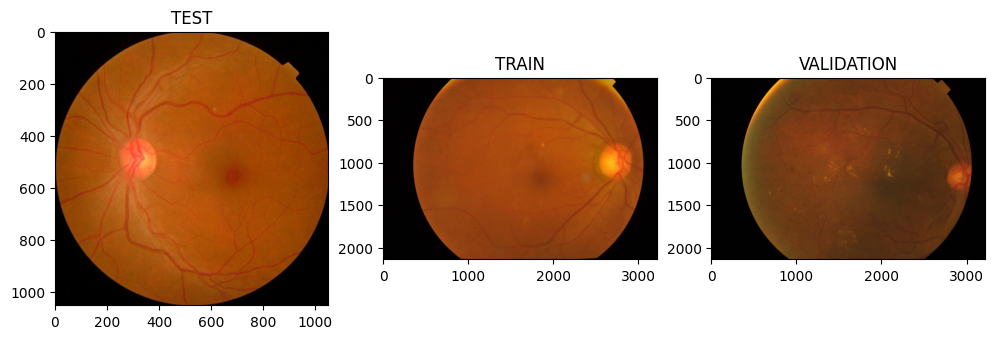

In [24]:
import matplotlib.pyplot as plt
import glob

# my_path = "drive/MyDrive/5980/"
my_path = "drive/MyDrive/"
test_image_path = "./" + my_path + "APTOS/test_images/test_images"
train_image_path = "./" + my_path + "APTOS/train_images/train_images"
val_image_path = "./" + my_path + "APTOS/val_images/val_images"

test_images = sorted(glob.glob(test_image_path + '/*.png'))
train_images = sorted(glob.glob(train_image_path + '/*.png'))
val_images = sorted(glob.glob(val_image_path + '/*.png'))

test_image = test_images[0]
train_image = train_images[0]
val_image = val_images[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].imshow(plt.imread(test_image), cmap='gray')
ax[0].set_title('TEST')

ax[1].imshow(plt.imread(train_image), cmap='gray')
ax[1].set_title('TRAIN')

ax[2].imshow(plt.imread(val_image), cmap='gray')
ax[2].set_title('VALIDATION')

plt.show()

In [25]:
import torch
import numpy as np

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Device: {device}")

2.5.1+cu121
Device: cuda


In [26]:
import os
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
from functools import lru_cache

class CustomDataset(Dataset):
    def __init__(self, image_dir, labels_csv, transform=None):
        self.image_dir = image_dir
        self.labels_df = pd.read_csv(labels_csv)
        self.transform = transform

        # Normalize IDs in the labels DataFrame
        self.labels_df['id_code'] = self.labels_df['id_code'].str.lower().str.strip()

    def __len__(self):
        return len(self.labels_df)

    @lru_cache(maxsize = 10_000)
    def __getitem__(self, idx):
        # Get image ID and label
        image_id = self.labels_df.iloc[idx]['id_code']
        label = self.labels_df.iloc[idx]['diagnosis']

        # Construct image path using os.path.join for platform-independent path handling
        image_path = os.path.join(self.image_dir, f"{image_id}.png")

        # Debug: Check the file path
        # print(f"Looking for: {image_path}")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"File not found: {image_path}")

        # Load the image
        image = Image.open(image_path)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label



Train Labels:
         id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0
Validation Labels:
         id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
Test Labels:
         id_code  diagnosis
0  e4dcca36ceb4          0
1  e4e343eaae2a          2
2  e4f12411fd85          4
3  e50b0174690d          0
4  e5197d77ec68          0


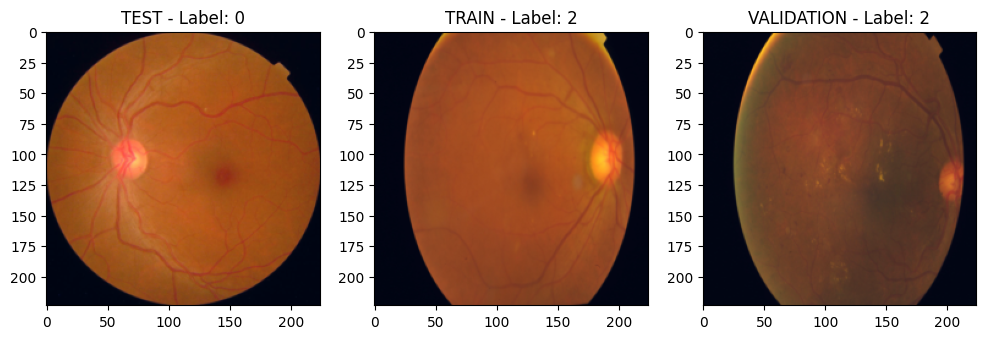

In [27]:
import pandas as pd
import glob
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os

test_image_path = "./" + my_path + "APTOS/test_images/test_images"
train_image_path = "./" + my_path + "APTOS/train_images/train_images"
val_image_path = "./" + my_path + "APTOS/val_images/val_images"

train_csv_path = "./" + my_path + "APTOS/train_1.csv"
val_csv_path = "./" + my_path + "APTOS/valid.csv"
test_csv_path = "./" + my_path + "APTOS/test.csv"

train_labels = pd.read_csv(train_csv_path)
val_labels = pd.read_csv(val_csv_path)
test_labels = pd.read_csv(test_csv_path)

train_images = sorted(glob.glob(train_image_path + '/*.png'))
val_images = sorted(glob.glob(val_image_path + '/*.png'))
test_images = sorted(glob.glob(test_image_path + '/*.png'))

# Verify CSV contents
print("Train Labels:\n", train_labels.head())
print("Validation Labels:\n", val_labels.head())
print("Test Labels:\n", test_labels.head())

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_and_transform(image_path, transform):
    image = Image.open(image_path)
    transformed_image = transform(image)
    transformed_image = transformed_image.permute(1, 2, 0).numpy()
    transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min())
    return transformed_image

def get_label(image_path, labels_df):
    image_id = os.path.splitext(os.path.basename(image_path))[0].lower().strip()
    labels_df['id_code'] = labels_df['id_code'].str.lower().str.strip()
    if image_id in labels_df['id_code'].values:
        label = labels_df.loc[labels_df['id_code'] == image_id, 'diagnosis'].values[0]
        return label
    else:
        return "Label Not Found"

train_image_transformed = load_and_transform(train_images[0], transform)
val_image_transformed = load_and_transform(val_images[0], transform)
test_image_transformed = load_and_transform(test_images[0], transform)

train_label = get_label(train_images[0], train_labels)
val_label = get_label(val_images[0], val_labels)
test_label = get_label(test_images[0], test_labels)

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].imshow(test_image_transformed)
ax[0].set_title(f'TEST - Label: {test_label}')

ax[1].imshow(train_image_transformed)
ax[1].set_title(f'TRAIN - Label: {train_label}')

ax[2].imshow(val_image_transformed)
ax[2].set_title(f'VALIDATION - Label: {val_label}')

plt.show()


In [28]:
from torch.utils.data import DataLoader

from pathlib import Path

train_dataset = CustomDataset(
    image_dir="./" + my_path + "APTOS/train_images/train_images",
    labels_csv="./" + my_path + "APTOS/train_1.csv",
    transform=transform
)

val_dataset = CustomDataset(
    image_dir="./" + my_path + "APTOS/val_images/val_images",
    labels_csv="./" + my_path + "APTOS/valid.csv",
    transform=transform
)

test_dataset = CustomDataset(
    image_dir="./" + my_path + "APTOS/test_images/test_images",
    labels_csv="./" + my_path + "APTOS/test.csv",
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

In [29]:
# Manually check the first 5 images and their labels
for i in range(5):
    image, label = train_dataset[i]
    print(f"Image {i}: Label = {label}")
    print(f"Image Path: {train_dataset.image_dir}/{train_dataset.labels_df.iloc[i]['id_code']}.png")



Image 0: Label = 2
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1ae8c165fd53.png
Image 1: Label = 1
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1b329a127307.png
Image 2: Label = 4
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1b32e1d775ea.png
Image 3: Label = 0
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1b3647865779.png
Image 4: Label = 0
Image Path: ./drive/MyDrive/APTOS/train_images/train_images/1b398c0494d1.png


In [30]:
from tqdm.auto import tqdm


def verify_loader_size(dataloader, dataset):
    samples = 0
    for batch, labels in tqdm(dataloader):
        samples += len(batch)
    return samples == len(dataset)

# This will take awhile as the images are loaded into memory and cached for the first time.
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and
    verify_loader_size(valid_loader, val_dataset)
)


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [31]:
# Notice how much faster it is after caching!
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and
    verify_loader_size(valid_loader, val_dataset)
)

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [32]:
import torch
from torch import nn, optim
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from torchvision.models import densenet121, DenseNet121_Weights, densenet161, DenseNet161_Weights, densenet169, DenseNet169_Weights, densenet201, DenseNet201_Weights
import matplotlib.pyplot as plt

def initialize_model(num_classes, device):
    weights = EfficientNet_B7_Weights.DEFAULT
    model = efficientnet_b7(weights=weights)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model.to(device)

def initialize_model_densenet121(num_classes, device):
    weights = DenseNet121_Weights.DEFAULT
    model = densenet121(weights=weights)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)

def initialize_model_densenet161(num_classes, device):
    weights = DenseNet161_Weights.DEFAULT
    model = densenet161(weights=weights)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)

def initialize_model_densenet169(num_classes, device):
    weights = DenseNet169_Weights.DEFAULT
    model = densenet169(weights=weights)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)

def initialize_model_densenet201(num_classes, device):
    weights = DenseNet201_Weights.DEFAULT
    model = densenet201(weights=weights)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)

def test_model(model, test_loader):
    model.eval()
    true_labels = []
    predicted_probabilities = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = nn.Softmax(dim=1)(outputs)
            true_labels.extend(labels.cpu().numpy())
            predicted_probabilities.extend(probabilities.cpu().numpy())

    return np.array(true_labels), np.array(predicted_probabilities)

def plot_learning_curves(training_losses, validation_losses, model_name=''):
    # Plot epoch wise training and validation losses (both in the same plot)
    assert len(training_losses) == len(validation_losses)

    plt.figure(figsize=(10,6))
    plt.plot(training_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(validation_losses, label='Validation Loss', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(model_name + ' Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

def train_model(model, loss_module, optimizer, train_loader, valid_loader, device, path='efficientnetb7', epochs=20, model_name=''):
    training_losses = []
    validation_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):

        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{epochs}", leave=False, unit='batch')

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_module(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        training_losses.append(train_loss)

        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_module(outputs, labels)
                running_loss += loss.item()

        valid_loss = running_loss / len(valid_loader)
        validation_losses.append(valid_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            torch.save({'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epoch': epoch + 1}, f"{path}_best.pth")
            print(f"Best model saved at epoch {epoch + 1}")

        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch + 1}, f"{path}_epoch_{epoch + 1}.pth")
    plot_learning_curves(training_losses, validation_losses, model_name)

    return training_losses, validation_losses


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 5

model = initialize_model(num_classes, device)

loss_module = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

model_densenet121 = initialize_model_densenet121(num_classes, device)
optimizer_densenet121 = optim.AdamW(model_densenet121.parameters(), lr=1e-4)

model_densenet161 = initialize_model_densenet161(num_classes, device)
optimizer_densenet161 = optim.AdamW(model_densenet161.parameters(), lr=1e-4)

model_densenet169 = initialize_model_densenet169(num_classes, device)
optimizer_densenet169 = optim.AdamW(model_densenet169.parameters(), lr=1e-4)

model_densenet201 = initialize_model_densenet201(num_classes, device)
optimizer_densenet201 = optim.AdamW(model_densenet201.parameters(), lr=1e-4)


Training epoch 1/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 1/20, Train Loss: 0.9365, Valid Loss: 1.0305
Best model saved at epoch 1


Training epoch 2/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2/20, Train Loss: 0.4829, Valid Loss: 0.7227
Best model saved at epoch 2


Training epoch 3/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 3/20, Train Loss: 0.2696, Valid Loss: 0.8614


Training epoch 4/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 4/20, Train Loss: 0.1417, Valid Loss: 0.8183


Training epoch 5/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 5/20, Train Loss: 0.0851, Valid Loss: 0.7528


Training epoch 6/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 6/20, Train Loss: 0.0568, Valid Loss: 0.7478


Training epoch 7/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 7/20, Train Loss: 0.0440, Valid Loss: 0.7291


Training epoch 8/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 8/20, Train Loss: 0.0355, Valid Loss: 0.8869


Training epoch 9/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 9/20, Train Loss: 0.0332, Valid Loss: 0.9123


Training epoch 10/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 10/20, Train Loss: 0.0241, Valid Loss: 0.8074


Training epoch 11/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 11/20, Train Loss: 0.0286, Valid Loss: 0.9426


Training epoch 12/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 12/20, Train Loss: 0.0306, Valid Loss: 0.8598


Training epoch 13/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 13/20, Train Loss: 0.0305, Valid Loss: 0.8515


Training epoch 14/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 14/20, Train Loss: 0.0286, Valid Loss: 0.8280


Training epoch 15/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 15/20, Train Loss: 0.0317, Valid Loss: 0.9435


Training epoch 16/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 16/20, Train Loss: 0.0288, Valid Loss: 0.9854


Training epoch 17/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 17/20, Train Loss: 0.0222, Valid Loss: 0.9572


Training epoch 18/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 18/20, Train Loss: 0.0167, Valid Loss: 0.9651


Training epoch 19/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 19/20, Train Loss: 0.0176, Valid Loss: 0.8248


Training epoch 20/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 20/20, Train Loss: 0.0106, Valid Loss: 0.9892


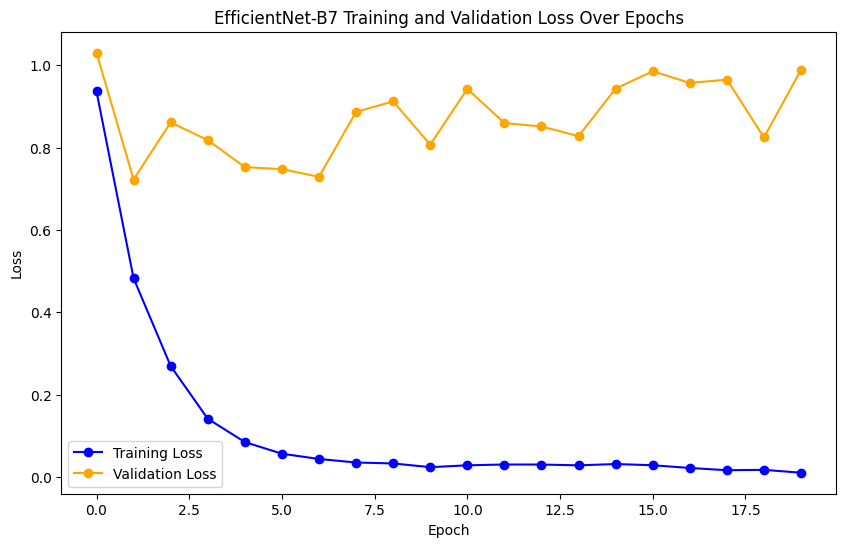

In [34]:
try:
    train_losses, val_losses = train_model(
        model, loss_module, optimizer, train_loader, valid_loader,
         device=device, path="efficientnetb7", epochs=20, model_name='EfficientNet-B7'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

In [55]:
# Load the best model checkpoint
checkpoint = torch.load("efficientnetb7_epoch_2.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

true_labels, predicted_probabilities = test_model(model, test_loader)

def accuracy(true_labels, predicted_probabilities):
  predicted_labels = [elem.argmax() for elem in predicted_probabilities]
  correct = 0
  for i in range(len(true_labels)):
    if true_labels[i] == predicted_labels[i]:
      correct +=1
  return correct/len(true_labels)

print("Accuracy:", accuracy(true_labels, predicted_probabilities))


<ipython-input-55-d2f92e862161>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("efficientnetb7_epoch_2.pth", map_location=device)


Accuracy: 0.7513661202185792


In [56]:
print(f"True Labels: {set(true_labels)}")
print(f"Predicted Probabilities: {predicted_probabilities[:10]}")  # Should contain values between 0 and 1


True Labels: {0, 1, 2, 3, 4}
Predicted Probabilities: [[9.48757708e-01 2.13207323e-02 4.28616628e-03 1.43853808e-02
  1.12500694e-02]
 [2.75669172e-02 6.13790870e-01 2.91267753e-01 2.09636185e-02
  4.64108661e-02]
 [1.37264989e-02 1.45525068e-01 3.05272549e-01 1.93489581e-01
  3.41986358e-01]
 [9.76864755e-01 1.12810265e-02 1.54243200e-03 6.11899747e-03
  4.19288268e-03]
 [9.86741364e-01 8.69680755e-03 7.36777205e-04 1.95928104e-03
  1.86569942e-03]
 [9.83694255e-01 7.59934122e-03 8.13806895e-04 4.77841077e-03
  3.11416271e-03]
 [3.79192090e-04 2.79754344e-02 8.29138577e-01 5.92084080e-02
  8.32984447e-02]
 [5.98996021e-02 6.54521227e-01 1.74305648e-01 2.10192651e-02
  9.02542695e-02]
 [3.83256674e-01 4.39542681e-01 6.72763735e-02 4.96368818e-02
  6.02873601e-02]
 [1.19387358e-01 4.65570599e-01 3.05108756e-01 4.71468009e-02
  6.27865493e-02]]


### ROC-AUC

In [57]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
def evaluate_roc_auc(true_labels, predicted_probabilities, model_name):
    # Binarize class labels
    true_labels_binarized = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure()

    # Set ROC curve colors
    colors = cycle(['lightsteelblue', 'cornflowerblue', 'royalblue', 'blue', 'darkblue'])

    # Plot ROC curve for each class
    for i, color in zip(range(5), colors):
        fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predicted_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Severity {i} ROC curve (area = {roc_auc[i]:0.2f})')

    # Plot micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_binarized.ravel(), predicted_probabilities.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr["micro"], tpr["micro"],
         linestyle=':', linewidth=2, color='salmon',
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')

    #Plot macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(5):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 5
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"],
         linestyle=':', linewidth=2, color='red',
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:0.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name + ' Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

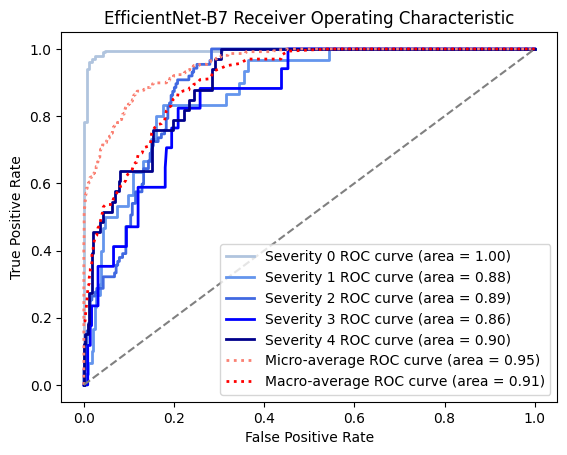

Severity 0 ROC-AUC: 1.00
Severity 1 ROC-AUC: 0.88
Severity 2 ROC-AUC: 0.89
Severity 3 ROC-AUC: 0.86
Severity 4 ROC-AUC: 0.90


In [58]:
roc_auc = evaluate_roc_auc(true_labels, predicted_probabilities, 'EfficientNet-B7')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc[cls]:.2f}")

### Confusion Matrix

In [59]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(true_labels, predicted_labels, model_name='', normalize=False):
    cm = confusion_matrix(true_labels, predicted_labels)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='viridis',
                xticklabels=range(5), yticklabels=range(5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name + ' Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.show()

    return cm

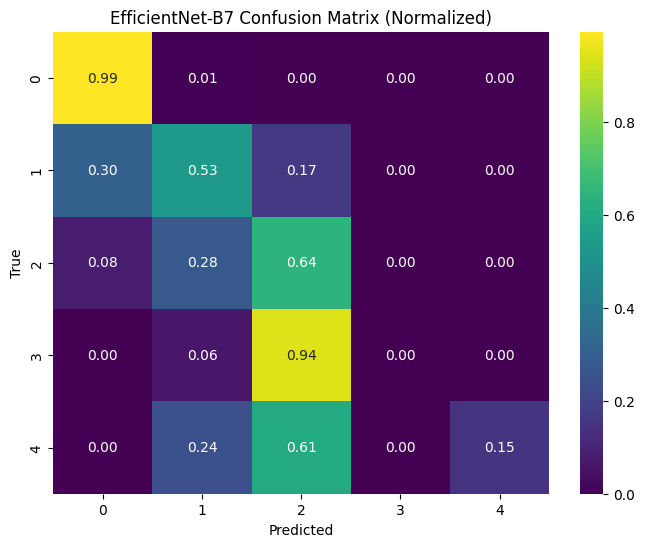

In [60]:
predicted_labels = np.argmax(predicted_probabilities, axis=1)
cm_normalized = plot_confusion_matrix(true_labels, predicted_labels, 'EfficientNet-B7', normalize=True)

### Grad-CAM

In [43]:
%pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=dbcfc74832f179f2d0d15a5863ffe4d83e49ce0f7520e18f987d1c957bebb14b
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [64]:
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_gradcam(model, cam, image_paths, transform):
    model.eval()
    cols = 5
    rows = (len(image_paths) + 1) // cols
    fig, ax = plt.subplots(rows, cols, figsize=(45, 9 * rows))
    for i, image_path in enumerate(image_paths):

        row = i // cols
        col = i % cols

        input_tensor, image = load_and_transform(image_path, transform)

        # Get model prediction for the current image along with the probability that it is positive
        with torch.no_grad():
            outputs = model(input_tensor.to(device))
            probs = float(torch.softmax(outputs, dim=1)[0]) # probability that it is positive
            predicted = torch.argmax(probs).item()
            confidence = probs[predicted].item()

        # Generate GradCAM heatmap
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]
        image_np = np.array(image, dtype=np.float32) / 255.0
        resized_cam = np.array(Image.fromarray(grayscale_cam).resize(image_np.shape[1::-1]))

        # Overlay GradCAM heatmap on the original image
        visualization = show_cam_on_image(image_np, resized_cam, use_rgb=True)

        ax[row, col].imshow(visualization)
        ax[row, col].set_title(f'Predicted: {predicted}\nConfidence: {confidence:.2f} (Probability: {(probs):.4f})')

    plt.show()


In [49]:
def get_last_conv_layer(model):
    last_conv = None
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            last_conv = module
    return last_conv

last_conv_layer = get_last_conv_layer(model)
print("Last Convolutional Layer:", last_conv_layer)

Last Convolutional Layer: Conv2d(640, 2560, kernel_size=(1, 1), stride=(1, 1), bias=False)


ValueError: too many values to unpack (expected 2)

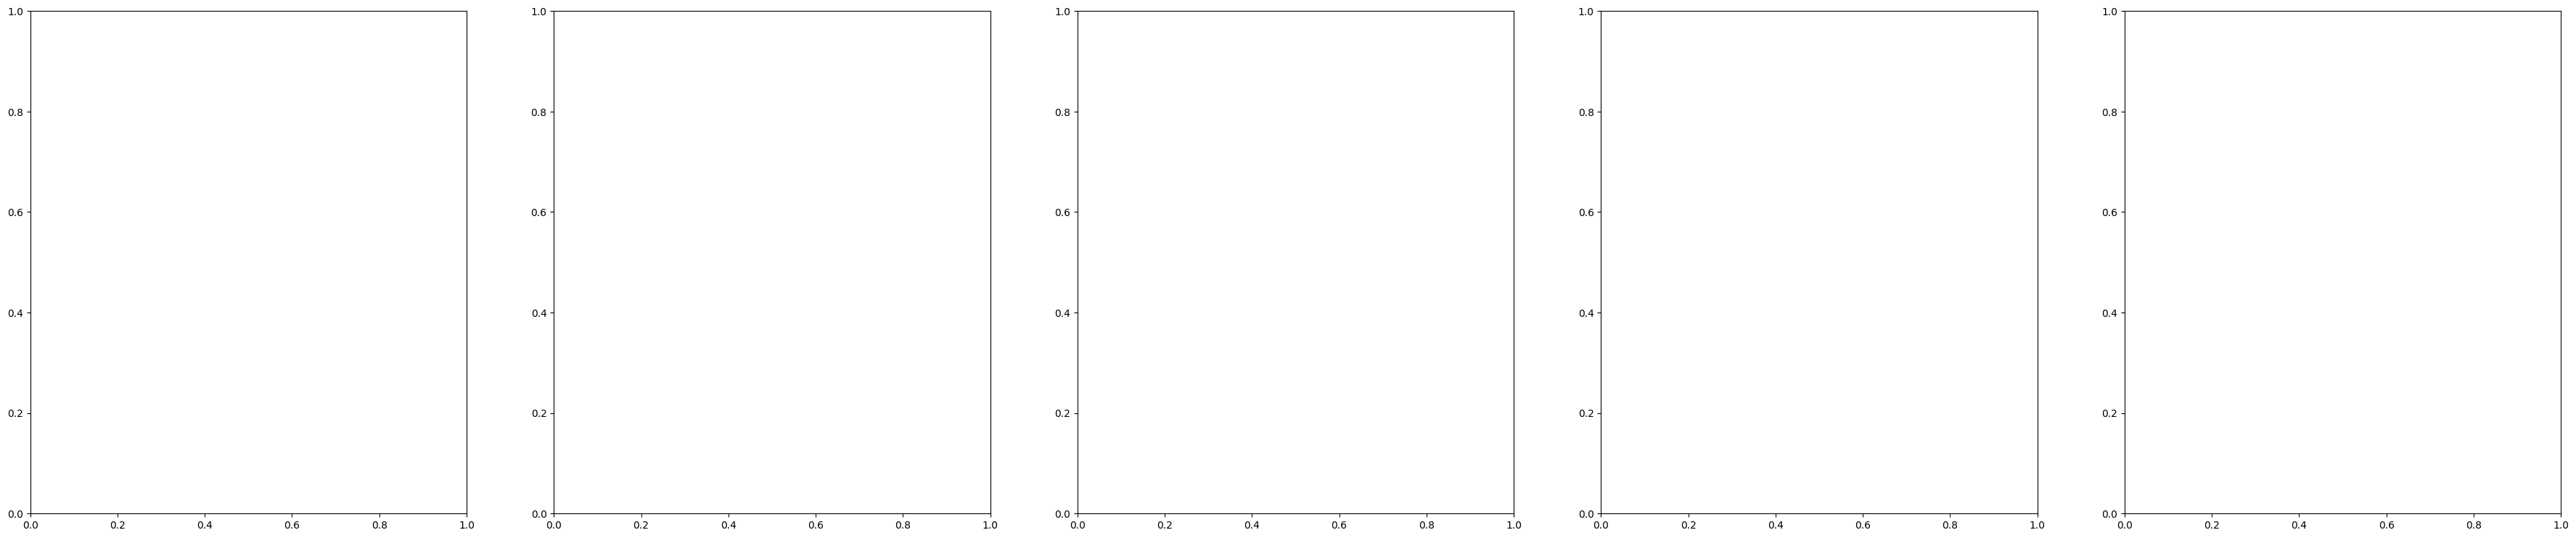

In [66]:
import random

no_dr_images = glob.glob(train_image_path + '/*.png')
mild_dr_images = glob.glob(train_image_path + '/*.png')
moderate_dr_images = glob.glob(train_image_path + '/*.png')
severe_dr_images = glob.glob(train_image_path + '/*.png')
proliferative_dr_images = glob.glob(train_image_path + '/*.png')

random_images = random.sample(no_dr_images, 5)

# target layer is the last convolution layer
target_layers = [model.features[-1]]

# Intialize gradcam
cam = GradCAM(model=model, target_layers=target_layers)

visualize_gradcam(model, cam, random_images, transform)


### DenseNet

Training epoch 1/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 1/20, Train Loss: 0.7355, Valid Loss: 0.5506
Best model saved at epoch 1


Training epoch 2/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2/20, Train Loss: 0.3777, Valid Loss: 0.4950
Best model saved at epoch 2


Training epoch 3/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 3/20, Train Loss: 0.1906, Valid Loss: 0.5105


Training epoch 4/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 4/20, Train Loss: 0.1012, Valid Loss: 0.5733


Training epoch 5/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 5/20, Train Loss: 0.0784, Valid Loss: 0.6277


Training epoch 6/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 6/20, Train Loss: 0.0542, Valid Loss: 0.7017


Training epoch 7/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 7/20, Train Loss: 0.0461, Valid Loss: 0.6595


Training epoch 8/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 8/20, Train Loss: 0.0325, Valid Loss: 0.6884


Training epoch 9/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 9/20, Train Loss: 0.0228, Valid Loss: 0.7480


Training epoch 10/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 10/20, Train Loss: 0.0125, Valid Loss: 0.7598


Training epoch 11/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 11/20, Train Loss: 0.0083, Valid Loss: 0.7754


Training epoch 12/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 12/20, Train Loss: 0.0062, Valid Loss: 0.7904


Training epoch 13/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 13/20, Train Loss: 0.0057, Valid Loss: 0.7989


Training epoch 14/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 14/20, Train Loss: 0.0054, Valid Loss: 0.7842


Training epoch 15/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 15/20, Train Loss: 0.0038, Valid Loss: 0.8021


Training epoch 16/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 16/20, Train Loss: 0.0023, Valid Loss: 0.8408


Training epoch 17/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 17/20, Train Loss: 0.0018, Valid Loss: 0.8496


Training epoch 18/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 18/20, Train Loss: 0.0015, Valid Loss: 0.8602


Training epoch 19/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 19/20, Train Loss: 0.0016, Valid Loss: 0.8821


Training epoch 20/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 20/20, Train Loss: 0.0018, Valid Loss: 0.8780


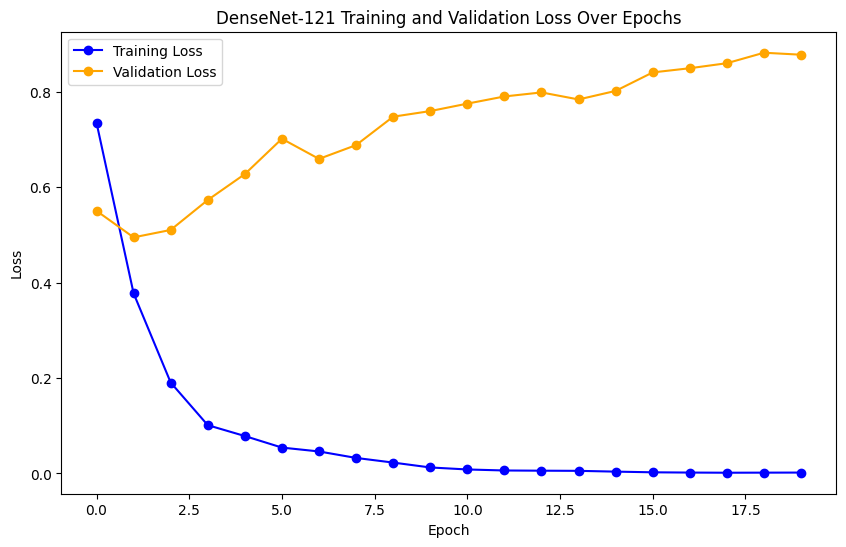

Training epoch 1/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 1/20, Train Loss: 0.6305, Valid Loss: 0.5316
Best model saved at epoch 1


Training epoch 2/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2/20, Train Loss: 0.3066, Valid Loss: 0.4761
Best model saved at epoch 2


Training epoch 3/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 3/20, Train Loss: 0.1434, Valid Loss: 0.5431


Training epoch 4/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 4/20, Train Loss: 0.0963, Valid Loss: 0.7671


Training epoch 5/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 5/20, Train Loss: 0.0922, Valid Loss: 0.5985


Training epoch 6/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 6/20, Train Loss: 0.0583, Valid Loss: 0.5878


Training epoch 7/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 7/20, Train Loss: 0.0384, Valid Loss: 0.6336


Training epoch 8/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 8/20, Train Loss: 0.0230, Valid Loss: 0.6676


Training epoch 9/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 9/20, Train Loss: 0.0158, Valid Loss: 0.6515


Training epoch 10/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 10/20, Train Loss: 0.0138, Valid Loss: 0.6676


Training epoch 11/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 11/20, Train Loss: 0.0160, Valid Loss: 0.6984


Training epoch 12/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 12/20, Train Loss: 0.0160, Valid Loss: 0.6592


Training epoch 13/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 13/20, Train Loss: 0.0179, Valid Loss: 0.6331


Training epoch 14/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 14/20, Train Loss: 0.0080, Valid Loss: 0.6369


Training epoch 15/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 15/20, Train Loss: 0.0085, Valid Loss: 0.6809


Training epoch 16/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 16/20, Train Loss: 0.0037, Valid Loss: 0.6777


Training epoch 17/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 17/20, Train Loss: 0.0024, Valid Loss: 0.6983


Training epoch 18/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 18/20, Train Loss: 0.0029, Valid Loss: 0.7169


Training epoch 19/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 19/20, Train Loss: 0.0035, Valid Loss: 0.7471


Training epoch 20/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 20/20, Train Loss: 0.0023, Valid Loss: 0.7247


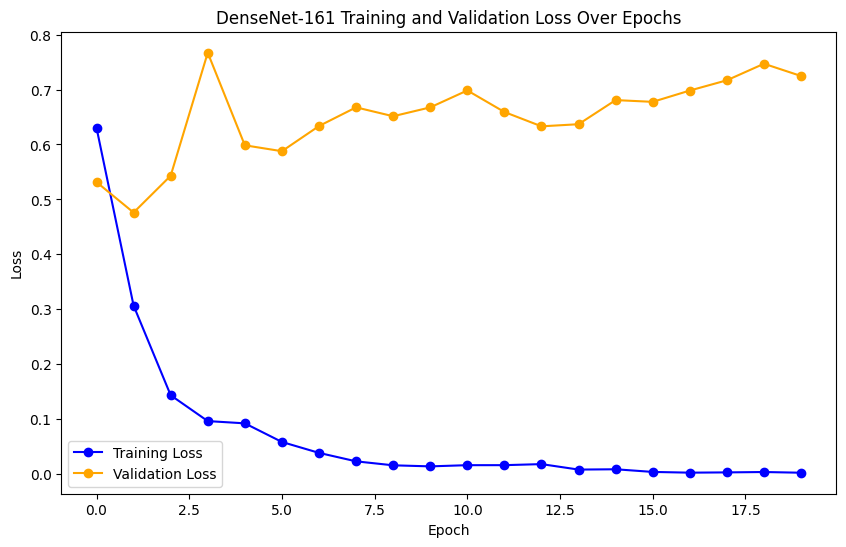

Training epoch 1/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 1/20, Train Loss: 0.7115, Valid Loss: 0.5260
Best model saved at epoch 1


Training epoch 2/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2/20, Train Loss: 0.3310, Valid Loss: 0.5425


Training epoch 3/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 3/20, Train Loss: 0.1486, Valid Loss: 0.4775
Best model saved at epoch 3


Training epoch 4/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 4/20, Train Loss: 0.0910, Valid Loss: 0.5514


Training epoch 5/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 5/20, Train Loss: 0.0720, Valid Loss: 0.6301


Training epoch 6/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 6/20, Train Loss: 0.0727, Valid Loss: 0.6491


Training epoch 7/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 7/20, Train Loss: 0.0544, Valid Loss: 0.6222


Training epoch 8/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 8/20, Train Loss: 0.0442, Valid Loss: 0.7257


Training epoch 9/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 9/20, Train Loss: 0.0366, Valid Loss: 0.6332


Training epoch 10/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 10/20, Train Loss: 0.0289, Valid Loss: 0.6725


Training epoch 11/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 11/20, Train Loss: 0.0168, Valid Loss: 0.6687


Training epoch 12/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 12/20, Train Loss: 0.0123, Valid Loss: 0.7052


Training epoch 13/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 13/20, Train Loss: 0.0076, Valid Loss: 0.6870


Training epoch 14/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 14/20, Train Loss: 0.0053, Valid Loss: 0.7176


Training epoch 15/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 15/20, Train Loss: 0.0059, Valid Loss: 0.7075


Training epoch 16/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 16/20, Train Loss: 0.0026, Valid Loss: 0.7372


Training epoch 17/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 17/20, Train Loss: 0.0019, Valid Loss: 0.7452


Training epoch 18/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 18/20, Train Loss: 0.0016, Valid Loss: 0.7641


Training epoch 19/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 19/20, Train Loss: 0.0014, Valid Loss: 0.7653


Training epoch 20/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 20/20, Train Loss: 0.0013, Valid Loss: 0.7841


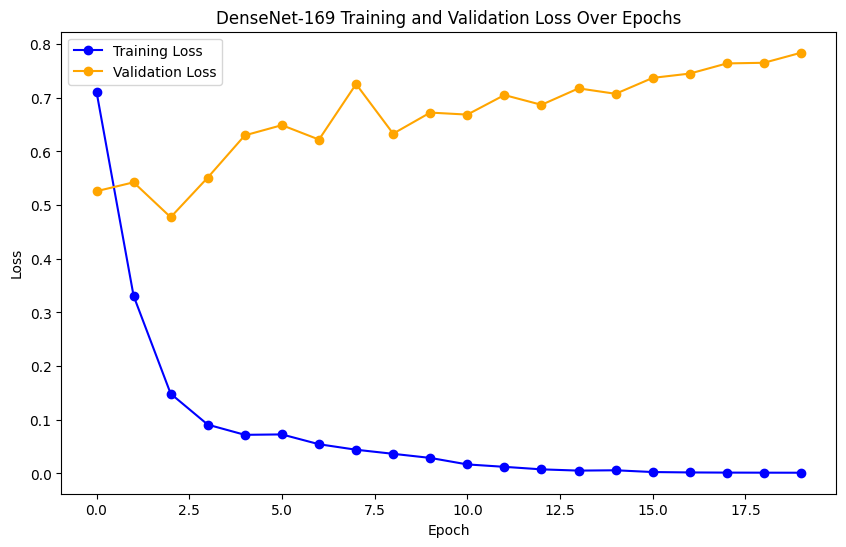

Training epoch 1/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 1/20, Train Loss: 0.6691, Valid Loss: 0.5469
Best model saved at epoch 1


Training epoch 2/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2/20, Train Loss: 0.3106, Valid Loss: 0.5193
Best model saved at epoch 2


Training epoch 3/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 3/20, Train Loss: 0.1342, Valid Loss: 0.5533


Training epoch 4/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 4/20, Train Loss: 0.0837, Valid Loss: 0.6930


Training epoch 5/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 5/20, Train Loss: 0.0739, Valid Loss: 0.5811


Training epoch 6/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 6/20, Train Loss: 0.0593, Valid Loss: 0.6340


Training epoch 7/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 7/20, Train Loss: 0.0429, Valid Loss: 0.6309


Training epoch 8/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 8/20, Train Loss: 0.0350, Valid Loss: 0.6671


Training epoch 9/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 9/20, Train Loss: 0.0253, Valid Loss: 0.6816


Training epoch 10/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 10/20, Train Loss: 0.0146, Valid Loss: 0.6883


Training epoch 11/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 11/20, Train Loss: 0.0118, Valid Loss: 0.7221


Training epoch 12/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 12/20, Train Loss: 0.0085, Valid Loss: 0.7527


Training epoch 13/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 13/20, Train Loss: 0.0083, Valid Loss: 0.7229


Training epoch 14/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 14/20, Train Loss: 0.0041, Valid Loss: 0.7459


Training epoch 15/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 15/20, Train Loss: 0.0023, Valid Loss: 0.7646


Training epoch 16/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 16/20, Train Loss: 0.0017, Valid Loss: 0.7775


Training epoch 17/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 17/20, Train Loss: 0.0014, Valid Loss: 0.7899


Training epoch 18/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 18/20, Train Loss: 0.0012, Valid Loss: 0.8001


Training epoch 19/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 19/20, Train Loss: 0.0011, Valid Loss: 0.8173


Training epoch 20/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 20/20, Train Loss: 0.0012, Valid Loss: 0.8087


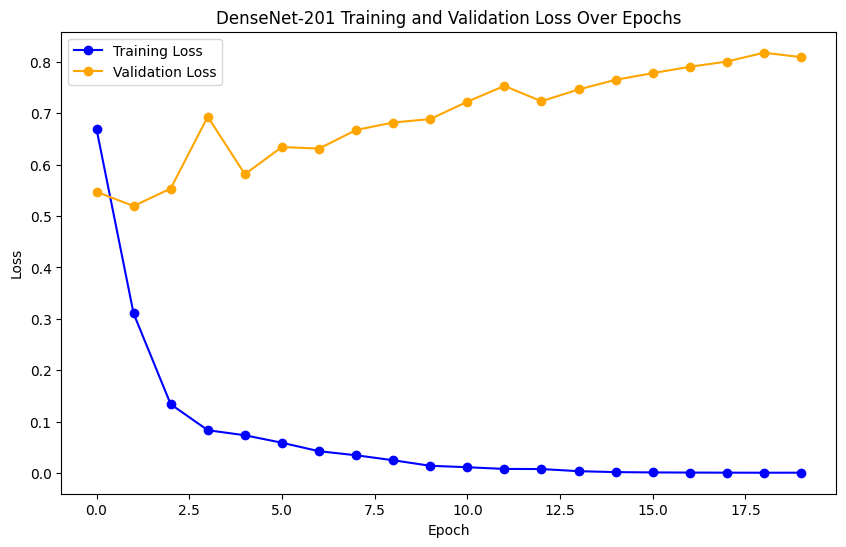

In [50]:
try:
    train_losses, val_losses = train_model(
        model_densenet121, loss_module, optimizer_densenet121, train_loader, valid_loader,
         device=device, path="densenet121", epochs=20, model_name='DenseNet-121'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

try:
    train_losses, val_losses = train_model(
        model_densenet161, loss_module, optimizer_densenet161, train_loader, valid_loader,
         device=device, path="densenet161", epochs=20, model_name='DenseNet-161'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

try:
    train_losses, val_losses = train_model(
        model_densenet169, loss_module, optimizer_densenet169, train_loader, valid_loader,
         device=device, path="densenet169", epochs=20, model_name='DenseNet-169'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

try:
    train_losses, val_losses = train_model(
        model_densenet201, loss_module, optimizer_densenet201, train_loader, valid_loader,
         device=device, path="densenet201", epochs=20, model_name='DenseNet-201'
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

In [61]:
checkpoint_densenet121 = torch.load("densenet121_epoch_2.pth", map_location=device)
model_densenet121.load_state_dict(checkpoint_densenet121["model_state_dict"])

checkpoint_densenet161 = torch.load("densenet161_epoch_2.pth", map_location=device)
model_densenet161.load_state_dict(checkpoint_densenet161["model_state_dict"])

checkpoint_densenet169 = torch.load("densenet169_epoch_3.pth", map_location=device)
model_densenet169.load_state_dict(checkpoint_densenet169["model_state_dict"])

checkpoint_densenet201 = torch.load("densenet201_epoch_2.pth", map_location=device)
model_densenet201.load_state_dict(checkpoint_densenet201["model_state_dict"])

true_labels_densenet121, predicted_probabilities_densenet121 = test_model(model_densenet121, test_loader)
true_labels_densenet161, predicted_probabilities_densenet161 = test_model(model_densenet161, test_loader)
true_labels_densenet169, predicted_probabilities_densenet169 = test_model(model_densenet169, test_loader)
true_labels_densenet201, predicted_probabilities_densenet201 = test_model(model_densenet201, test_loader)

print(f"\nDenseNet-121 True Labels: {set(true_labels_densenet121)}")
print(f"DenseNet-161 True Labels: {set(true_labels_densenet161)}")
print(f"DenseNet-169 True Labels: {set(true_labels_densenet169)}")
print(f"DenseNet-201 True Labels: {set(true_labels_densenet201)}\n")

print(f"DenseNet-121 Predicted Probabilities: \n{predicted_probabilities_densenet121[:10]}\n")
print(f"DenseNet-161 Predicted Probabilities: \n{predicted_probabilities_densenet161[:10]}\n")
print(f"DenseNet-169 Predicted Probabilities: \n{predicted_probabilities_densenet169[:10]}\n")
print(f"DenseNet-201 Predicted Probabilities: \n{predicted_probabilities_densenet201[:10]}\n")


print("Accuracy DenseNet-121:", accuracy(true_labels_densenet121, predicted_probabilities_densenet121))
print("Accuracy DenseNet-161:", accuracy(true_labels_densenet161, predicted_probabilities_densenet161))
print("Accuracy DenseNet-169:", accuracy(true_labels_densenet169, predicted_probabilities_densenet169))
print("Accuracy DenseNet-201:", accuracy(true_labels_densenet201, predicted_probabilities_densenet201))


<ipython-input-61-41a9f191b64e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_densenet121 = torch.load("densenet121_epoch_2.pth", map_location=device)
<ipython


DenseNet-121 True Labels: {0, 1, 2, 3, 4}
DenseNet-161 True Labels: {0, 1, 2, 3, 4}
DenseNet-169 True Labels: {0, 1, 2, 3, 4}
DenseNet-201 True Labels: {0, 1, 2, 3, 4}

DenseNet-121 Predicted Probabilities: 
[[9.5815963e-01 1.8307334e-02 1.3881790e-02 4.9363994e-03 4.7148075e-03]
 [1.0782754e-03 3.2068133e-02 9.5430887e-01 6.9305361e-03 5.6141918e-03]
 [7.5203208e-03 2.6702361e-02 3.7933722e-02 7.9876018e-01 1.2908345e-01]
 [8.9210713e-01 5.8937401e-02 3.0361189e-02 8.5444925e-03 1.0049797e-02]
 [9.6940088e-01 1.5045737e-02 5.9227264e-03 4.1325339e-03 5.4980428e-03]
 [9.8507023e-01 7.1684653e-03 2.1911680e-03 4.4416920e-03 1.1284675e-03]
 [6.2558561e-04 5.6690103e-03 9.2276454e-01 2.2968570e-02 4.7972277e-02]
 [1.4121996e-02 3.1966916e-01 4.6648315e-01 4.6983499e-02 1.5274225e-01]
 [3.2819260e-02 9.0849781e-01 4.9645241e-02 2.8062633e-03 6.2314020e-03]
 [3.4297142e-02 3.9055400e-02 9.0847456e-01 1.1702003e-02 6.4709364e-03]]

DenseNet-161 Predicted Probabilities: 
[[9.4704455e-01 2.47

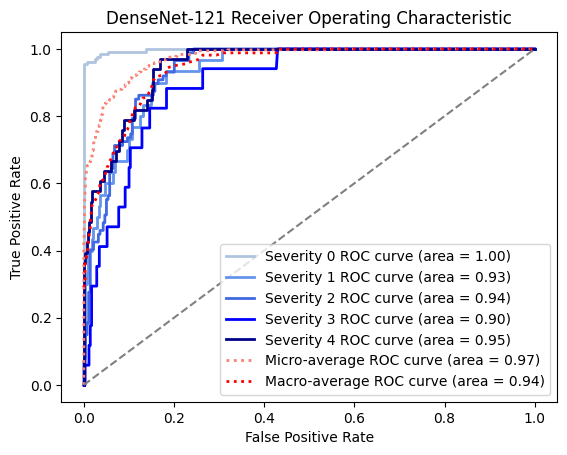

Severity 0 ROC-AUC: 1.00
Severity 1 ROC-AUC: 0.93
Severity 2 ROC-AUC: 0.94
Severity 3 ROC-AUC: 0.90
Severity 4 ROC-AUC: 0.95


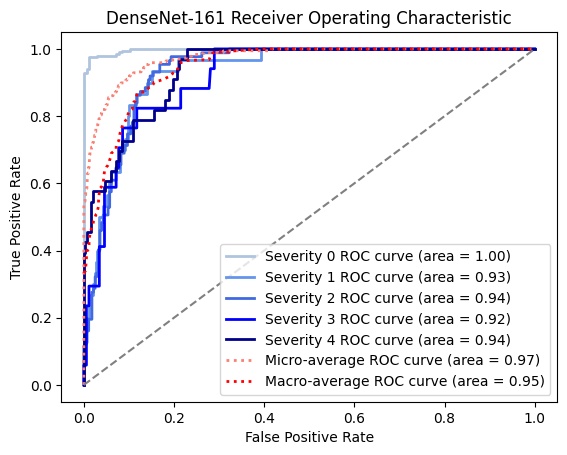

Severity 0 ROC-AUC: 1.00
Severity 1 ROC-AUC: 0.93
Severity 2 ROC-AUC: 0.94
Severity 3 ROC-AUC: 0.92
Severity 4 ROC-AUC: 0.94


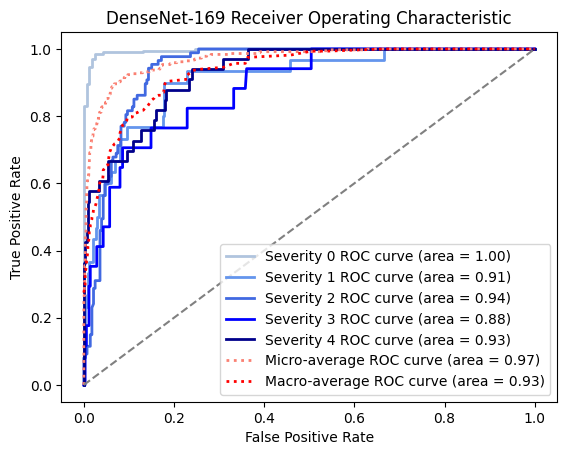

Severity 0 ROC-AUC: 1.00
Severity 1 ROC-AUC: 0.91
Severity 2 ROC-AUC: 0.94
Severity 3 ROC-AUC: 0.88
Severity 4 ROC-AUC: 0.93


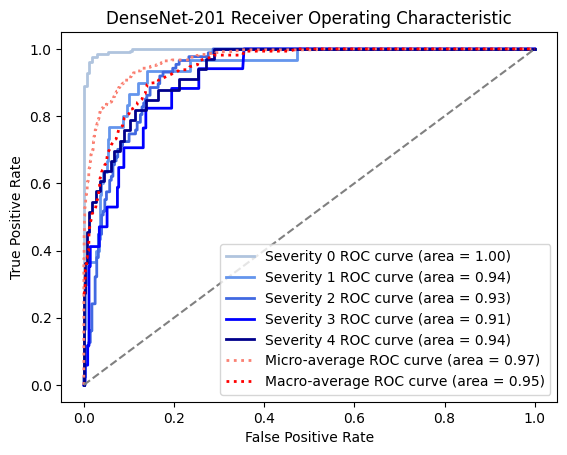

Severity 0 ROC-AUC: 1.00
Severity 1 ROC-AUC: 0.94
Severity 2 ROC-AUC: 0.93
Severity 3 ROC-AUC: 0.91
Severity 4 ROC-AUC: 0.94


In [62]:
roc_auc_densenet121 = evaluate_roc_auc(true_labels_densenet121, predicted_probabilities_densenet121, 'DenseNet-121')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc_densenet121[cls]:.2f}")

roc_auc_densenet161 = evaluate_roc_auc(true_labels_densenet161, predicted_probabilities_densenet161, 'DenseNet-161')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc_densenet161[cls]:.2f}")

roc_auc_densenet169 = evaluate_roc_auc(true_labels_densenet169, predicted_probabilities_densenet169, 'DenseNet-169')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc_densenet169[cls]:.2f}")

roc_auc_densenet201 = evaluate_roc_auc(true_labels_densenet201, predicted_probabilities_densenet201, 'DenseNet-201')
for cls in range(5):
    print(f"Severity {cls} ROC-AUC: {roc_auc_densenet201[cls]:.2f}")


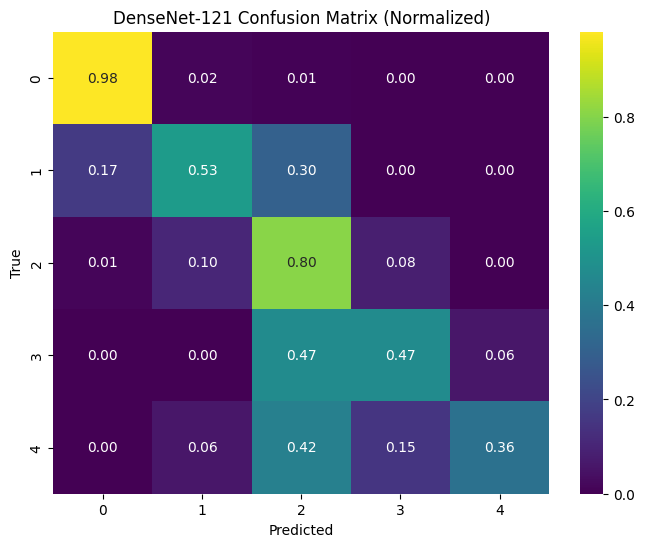

DenseNet-121 Confusion Matrix:
 [[0.9798995  0.01507538 0.00502513 0.         0.        ]
 [0.16666667 0.53333333 0.3        0.         0.        ]
 [0.01149425 0.10344828 0.8045977  0.08045977 0.        ]
 [0.         0.         0.47058824 0.47058824 0.05882353]
 [0.         0.06060606 0.42424242 0.15151515 0.36363636]]


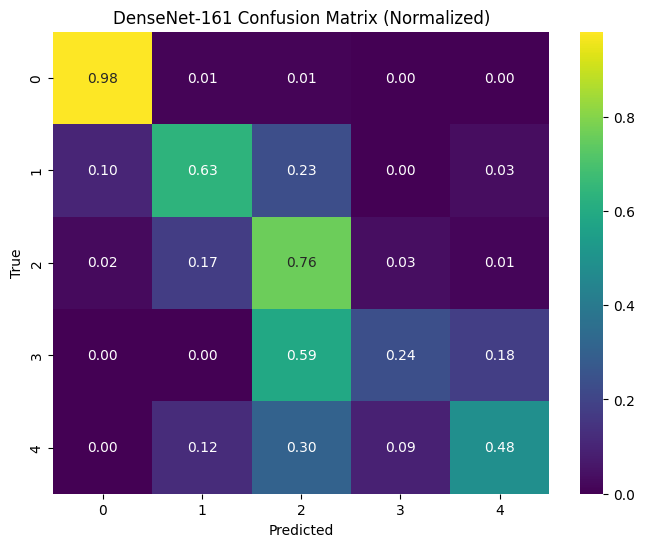

DenseNet-161 Confusion Matrix:
 [[0.9798995  0.01005025 0.01005025 0.         0.        ]
 [0.1        0.63333333 0.23333333 0.         0.03333333]
 [0.02298851 0.17241379 0.75862069 0.03448276 0.01149425]
 [0.         0.         0.58823529 0.23529412 0.17647059]
 [0.         0.12121212 0.3030303  0.09090909 0.48484848]]


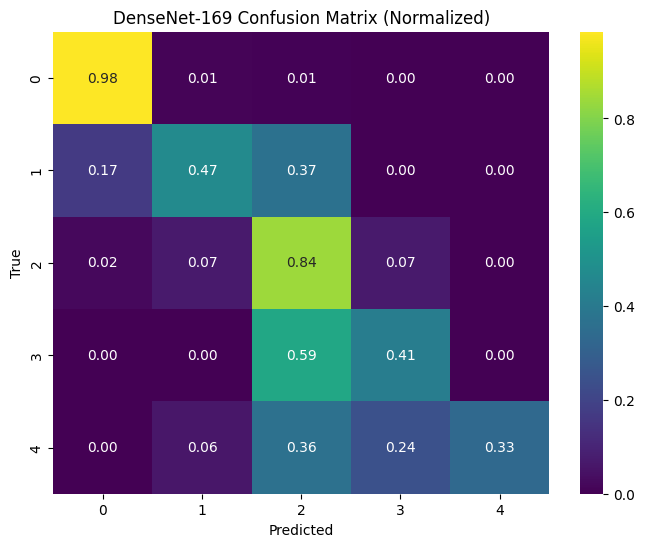

DenseNet-169 Confusion Matrix:
 [[0.98492462 0.01005025 0.00502513 0.         0.        ]
 [0.16666667 0.46666667 0.36666667 0.         0.        ]
 [0.02298851 0.06896552 0.83908046 0.06896552 0.        ]
 [0.         0.         0.58823529 0.41176471 0.        ]
 [0.         0.06060606 0.36363636 0.24242424 0.33333333]]


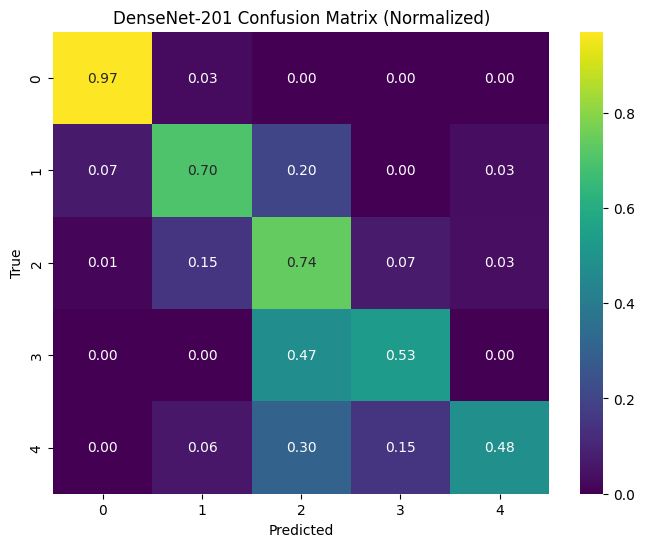

DenseNet-201 Confusion Matrix:
 [[0.96984925 0.03015075 0.         0.         0.        ]
 [0.06666667 0.7        0.2        0.         0.03333333]
 [0.01149425 0.14942529 0.73563218 0.06896552 0.03448276]
 [0.         0.         0.47058824 0.52941176 0.        ]
 [0.         0.06060606 0.3030303  0.15151515 0.48484848]]


In [63]:
predicted_labels_densenet121 = np.argmax(predicted_probabilities_densenet121, axis=1)
cm_densenet121 = plot_confusion_matrix(true_labels_densenet121, predicted_labels_densenet121, 'DenseNet-121', normalize=True)
print(f'DenseNet-121 Confusion Matrix:\n {cm_densenet121}')

predicted_labels_densenet161 = np.argmax(predicted_probabilities_densenet161, axis=1)
cm_densenet161 = plot_confusion_matrix(true_labels_densenet161, predicted_labels_densenet161, 'DenseNet-161', normalize=True)
print(f'DenseNet-161 Confusion Matrix:\n {cm_densenet161}')

predicted_labels_densenet169 = np.argmax(predicted_probabilities_densenet169, axis=1)
cm_densenet169 = plot_confusion_matrix(true_labels_densenet169, predicted_labels_densenet169, 'DenseNet-169', normalize=True)
print(f'DenseNet-169 Confusion Matrix:\n {cm_densenet169}')

predicted_labels_densenet201 = np.argmax(predicted_probabilities_densenet201, axis=1)
cm_densenet201 = plot_confusion_matrix(true_labels_densenet201, predicted_labels_densenet201, 'DenseNet-201', normalize=True)
print(f'DenseNet-201 Confusion Matrix:\n {cm_densenet201}')